### The next notebook shows an example script for simple solution of Named Entity Recognition task with BiLSTM without any feature engineering and advanced techniques

### Data preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import re
import pandas as pd #we will need it a bit just to easily handle data from .csv file
from collections import Counter

In [2]:
# The annotatied corpus I've took from here
# https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

# Lets see what is there
source = pd.read_csv('testdata/ner_dataset.csv', encoding = 'latin1', sep=',')
source.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


Amount of initial sentences 47959
Max sentence length-  104


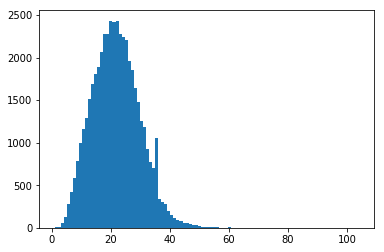

In [3]:
source['Word'] = source['Word'].str.lower() #Lets make all words lowercase. 
                                            # Basically its doubtable approach in this case: we 
                                            # reduce dimensiality (less unique words) but skip difference 
                                            # between of some words (like us (pronoun) and US (geo location))
                                            # so its subject for experiments then common approach
                
# Lets find all indeces the every new sentence starts                
sents_indeces = source[pd.notnull(source['Sentence #'])].index
sents_number = len(sents_indeces)
print('Amount of initial sentences', sents_number)

# and this trick gives sentences length distribution
diff = np.diff(sents_indeces)

# to future calculations we need to make all sequences length equal. One of the approach to pad all sentences
# to the max lenght in the corpus. If the corpus is big enough you can just choose length which will cover 
# 99% of cases (in current distribution such length is 60)
maxlen = max(diff)
print('Max sentence length- ', maxlen)

# Lets watch on it
plt.hist(diff, bins=100)
plt.show()

In [4]:
# Split words and tags on sentences
all_sentences = np.array([np.split(source.Word.values, sents_indeces[1:]),
                          np.split(source.Tag.values, sents_indeces[1:])])

# then just mix sentences and take 85% for training and 15% for test
index = np.random.permutation(range(sents_number))

train_sentences = all_sentences[:,index[:int(0.85*sents_number)]]
train_sentences_idx = np.cumsum([len(sent) for sent in train_sentences[1,:]])

test_sentences = all_sentences[:,index[int(0.85*sents_number):]]
test_sentences_idx = np.cumsum([len(sent) for sent in test_sentences[1,:]])

print('Amount of sentences for train', train_sentences.shape[1])
print('Amount of sentences for test', test_sentences.shape[1])

Amount of sentences for train 40765
Amount of sentences for test 7194


In [5]:
# For the next few steps we need unroll sentences again to the list of tokens, but only train sentences 
train_tags = np.concatenate(train_sentences[1,:])
train_tokens = np.concatenate(train_sentences[0,:])

# Lets see the tag distribution over the train corpus 
train_tags_counts = Counter(train_tags)
for k,i in train_tags_counts.items():
    if i<1000: c = '217' # highlight tags which have less then 1000 examples in train courpus
    else: c = '231'
    print('\033[38;5;16;48;5;{}m{:15}{:15}'.format(c,k,i)) 

B-tim                    17295
B-org                    17001
I-tim                     5486
I-geo                     6290
I-org                    14216
B-geo                    32090
I-gpe                      169
B-eve                      258
I-art                      248
B-gpe                    13450
I-eve                      210
B-art                      338
B-nat                      173
O                       754834
B-per                    14504
I-nat                       44
I-per                    14666


In [6]:
# We see how our problem is unbalanced. The difference between "O" and "I-nat" for example is enermous and it
# will bring consequances we meet on the next stemps.

# Lets make our solution a bit closer to real life problem. Some words might be unknown for the model after
# train, so we choose randomly a small amount of words which appeared only once in corpus and changed them to be
# "Unknown" letting the model to train on cases, where unknown word can appear 

words2Unk = np.random.permutation([k for k,i in Counter(train_tokens).items() if i==1])
words2Unk = words2Unk[:int(len(words2Unk)*0.05)]
print('Amount of words be changed to Unk', len(words2Unk))

idx2Unk = np.ravel([np.where(train_tokens==w) for w in words2Unk])
train_tokens[idx2Unk] = 'Unk'

Amount of words be changed to Unk 620


In [7]:
# Then build dictionaries which to convert our tokens and tags to indeces and vice-versa
# doing it on train corpus only

u_tokens = np.unique(train_tokens)
u_tags = np.unique(train_tags)

print('unique tokens (vocabluary size) -', u_tokens.shape)
print('unique tags (output features) -', u_tags.shape)

token2indices = dict((c, i) for i, c in enumerate(u_tokens))
indices2tokens = dict((i, c) for i, c in enumerate(u_tokens))

token2indices['<pad>'] = len(u_tokens)
indices2tokens[len(u_tokens)] = '<pad>'

tags2indices = dict((c, i) for i, c in enumerate(u_tags))
indices2tags = dict((i, c) for i, c in enumerate(u_tags))

unique tokens (vocabluary size) - (29169,)
unique tags (output features) - (17,)


In [8]:
# convert train tokens to indeces

train_tokens_num = np.array([token2indices[w] for w in train_tokens])
train_tags_num = np.array([tags2indices[w] for w in train_tags])

In [9]:
# convert test tokens to indeces

# additional function is required, cos probably some unknown words could be met in test corpus (like in real 
# live)
def get_index(w, d):
    if w in d:
        return d[w]
    else:
        return d['Unk']
    
test_tokens_num = np.array([get_index(w, token2indices) for w in np.concatenate(test_sentences[0,:])])
test_tags_num = np.array([get_index(w, tags2indices) for w in np.concatenate(test_sentences[1,:])])

In [10]:
# then split converted tokens and tags to sentences again and pad them

def num_pad(array, m, _dict, k):
    l = len(array)
    return np.pad(array, [0,m-l], 'constant', constant_values=( _dict[k]))

train_tokens_num_sents = [num_pad(s, maxlen, token2indices, '<pad>')  for s 
                          in np.split(train_tokens_num, train_sentences_idx)]
train_tags_num_sents = [num_pad(s, maxlen, tags2indices, 'O') for s 
                        in np.split(train_tags_num, train_sentences_idx)]

test_tokens_num_sents = [num_pad(s, maxlen, token2indices, '<pad>')  for s 
                          in np.split(test_tokens_num, test_sentences_idx)]
test_tags_num_sents = [num_pad(s, maxlen, tags2indices, 'O') for s 
                        in np.split(test_tags_num, test_sentences_idx)]

In [11]:
# prepare train and test examples to the shape our LSTM NN requires:
# (num of features, batch size, timesteps)
# As the word feature we pass the index of word in vocabluary and let embedding layer to find the best
# representation vector for this task

x_train = np.array(train_tokens_num_sents)
x_train = x_train.reshape(1, x_train.shape[0], x_train.shape[1])
y_train_indeces = np.array(train_tags_num_sents).T
y_train = np.eye(u_tags.shape[0]).astype(np.uint8)[y_train_indeces].T
print('Shapes of train inputs x = {}, y = {}'.format(x_train.shape, y_train.shape))

Shapes of train inputs x = (1, 40766, 104), y = (17, 40766, 104)


In [12]:
x_test = np.array(test_tokens_num_sents)
x_test = x_test.reshape(1, x_test.shape[0], x_test.shape[1])
y_test_indeces = np.array(test_tags_num_sents).T
y_test = np.eye(u_tags.shape[0]).astype(np.uint8)[y_test_indeces].T
print('Shapes of train inputs x = {}, y = {}'.format(x_test.shape, x_test.shape))

Shapes of train inputs x = (1, 7195, 104), y = (1, 7195, 104)


In [13]:
# We deed a lot of manipulations with tokens, tags and indeces and it could be a good approach to check
# what actually we have got before training
idx = np.random.choice(range(x_test.shape[1]))
seq_len = 25
print('\033[38;5;15;48;5;232m{:30}{:15}{:30}{:15}'.format('Train tokens', 'Train tags', 
                                                          'Test tokens', 'Test tags'))
for el in zip([indices2tokens[w] for w in x_train[0,idx,:seq_len]], 
              [indices2tags[w] for w in np.argmax(y_train[:,idx,:seq_len], axis=0)],
              [indices2tokens[w] for w in x_test[0,idx,:seq_len]], 
              [indices2tags[w] for w in np.argmax(y_test[:,idx,:seq_len], axis=0)]):
    print('\033[38;5;16;48;5;230m{:30}{:15}\033[38;5;16;48;5;194m{:30}{:15}'.format(el[0], el[1], 
                                                                                    el[2], el[3]))

Train tokens                  Train tags     Test tokens                   Test tags      
in                            O              in                            O              
a                             O              may                           B-tim          
separate                      O              ,                             O              
development                   O              a                             O              
,                             O              moscow                        B-geo          
attorneys                     O              court                         O              
for                           O              sentenced                     O              
ousted                        O              the                           O              
leader                        O              two                           O              
saddam                        B-per          men                           O              

In [14]:
# Looks fine!

# The only last preprocesssing is reshape tags of test examples to check our model 
# in efficient way

sh = y_test.shape
_y_test = y_test.reshape(sh[0], sh[1]*sh[2])
print(_y_test.shape)

(17, 748280)


In [15]:
# the next function will be executed every n epoch to show how the training is going and 
# estimate the model


def on_epoch_end(*args):
    if args[1] % 1 == 0:
        print()
        print("Cost after epoch %i: %f" %(args[1], args[2]))
        num_outputs = len(u_tags)
        _y_pred = np.around(args[0].predict(x_test))
        _y_pred = _y_pred.reshape(sh[0], sh[1]*sh[2])
        s = np.argmax(_y_pred[:,:], axis=0)
        r = np.argmax(_y_test[:,:], axis=0)
        gacc = np.sum(r==s)/_y_test.shape[1]
        print('General accurancy', gacc, '\n')

        header = '\033[38;5;15;48;5;232m{:15}{:15}{:15}{:15}{:15}'
        line = '\033[38;5;16;48;5;{}m{:15}{:10.8f}{:15.8f}{:15.8f}{:15}'
        print(header.format('Tag','Precision','Recall','F1','Train tags'))

        accurancy = np.empty(num_outputs)
        precision = np.empty(num_outputs)
        recall = np.empty(num_outputs)
        f1 = np.empty(num_outputs)
        for num, name in indices2tags.items():
            selected = _y_pred[num,:]==1
            relevant = _y_test[num,:]==1
            tp = np.count_nonzero(selected*relevant)
            fp = np.count_nonzero(selected*(relevant-1))
            fn = np.count_nonzero((selected-1)*relevant)
            accurancy[num] = tp/np.count_nonzero(relevant)
            if accurancy[num] == 0:
                precision[num], recall[num], f1[num] = [0,0,0]
            else:
                precision[num] = (tp / (tp + fp))
                recall[num] = (tp / (tp + fn))
                f1[num] = 2*((precision[num] * recall[num])/(precision[num] + recall[num]))
            if f1[num]<0.6: c = '217' #highlight less then 0.6 f1 rate
            else: c = '231'
            print(line.format(c, name, precision[num], recall[num], f1[num], train_tags_counts[name]))
        print('\033[38;5;16;48;5;231m')

In [16]:
from mylab.layers import layer, lstm_layer, rnn_layer, embedding_layer, brnn
import numpy as np
from mylab import nnet
from mylab.utils import define_minibatches, progress, tanh, softmax

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

model = nnet()
model.add(embedding_layer(64, len(token2indices))) # embedding layer takes number of hidden 
                                                   # units and vocabluary
                                                   # size
model.add(brnn(lstm_layer(32))) # add LSTM layer inside BRNN wrapper, 
                                # hidden units = 32 (activation function is tanh by default)
model.add(layer(17, softmax))   # activation function - softmax
model.report_function = on_epoch_end # add report function we specified before 

Dimensional checking...

input shape - (1, 40766, 104)

layer 0 output shape -  (64, 40766, 104)
layer 1 output shape -  (64, 40766, 104)
layer 2 output shape -  (17, 40766, 104)
Parameters are initialized

epoch 0 -[============================================================] 100.0% ...0.07744082775099649
Cost after epoch 0: 0.077441
General accurancy 0.9874071203292885 

Tag            Precision      Recall         F1             Train tags     
B-art          0.00000000     0.00000000     0.00000000            338
B-eve          0.00000000     0.00000000     0.00000000            258
B-geo          0.85485446     0.78790061     0.82001312          32090
B-gpe          0.94718910     0.91900826     0.93288591          13450
B-nat          0.00000000     0.00000000     0.00000000            173
B-org          0.80775194     0.49745385     0.61571794          17001
B-per          0.82448790     0.71238938     0.76435045          14504
B-tim          0.88607155     0.83969717     0.862

epoch 5 -[============================================================] 100.0% ...0.015384344708649782
Cost after epoch 5: 0.015384
General accurancy 0.9901280269417865 

Tag            Precision      Recall         F1             Train tags     
B-art          0.66666667     0.12500000     0.21052632            338
B-eve          0.85714286     0.24000000     0.37500000            258
B-geo          0.84878311     0.85397911     0.85137318          32090
B-gpe          0.96111111     0.92933884     0.94495798          13450
B-nat          0.87500000     0.25000000     0.38888889            173
B-org          0.72967112     0.64258434     0.68336436          17001
B-per          0.82686437     0.76267096     0.79347144          14504
B-tim          0.90409075     0.86570112     0.88447957          17295
I-art          0.00000000     0.00000000     0.00000000            248
I-eve          0.50000000     0.06976744     0.12244898            210
I-geo          0.76047904     0.67793594   

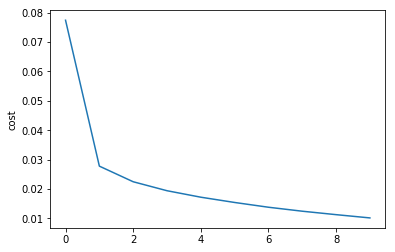

In [18]:
# finally train the model with given hyperparameters

results = model.train(x_train, y_train, lr = 0.001, num_epoch = 10, plot = True, 
                      mb = 8, clip_value = None, epoch_bar = True)

#### Discussion
##### As we see, the results are qiote good but still are not perfect. And the reseason is unbalanced problem. It's obvious we have low F1 rate on tags which have low amount of examples in train corpus. During evaluation the test corpus has them even less, qiote possible presented by unknown words, and that lead to low accurancy. There are few techniques which aimed to handle such problems and show state-of-the-art results like models with attention and/or comprehensive feature engineering or even CNN for NER tasks.
##### For those who would like to experiment with or repeat the solution using GPU the tensorflow script is presented in the next cells

In [19]:
x_train_tf = np.array(train_tokens_num_sents)
y_train_indeces = np.array(train_tags_num_sents)
y_train_tf = np.eye(u_tags.shape[0]).astype(np.uint8)[y_train_indeces]
print('Shapes of train inputs x = {}, y = {}'.format(x_train_tf.shape, y_train_tf.shape))

Shapes of train inputs x = (40766, 104), y = (40766, 104, 17)


In [20]:
x_test_tf = np.array(test_tokens_num_sents)
y_test_indeces = np.array(test_tags_num_sents)
y_test_tf = np.eye(u_tags.shape[0]).astype(np.uint8)[y_test_indeces]
print('Shapes of train inputs x = {}, y = {}'.format(x_test_tf.shape, x_test_tf.shape))

Shapes of train inputs x = (7195, 104), y = (7195, 104)


In [22]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/home/ivan/miniconda3/envs/env2_35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
g = tf.Graph()

sess = tf.InteractiveSession(graph=g)

with g.as_default():
  
    with tf.device('/cpu:0'): # in case you are using GPU -  change "c" to "g"
      
        vocab_size = len(token2indices)
        num_features = 1
        num_outputs = len(tags2indices)

        learning_rate = 0.001
        num_epochs = 10
        batch_size = 8

        X = tf.placeholder(tf.float32, [None, None])
        Y = tf.placeholder(tf.float32, [None, num_outputs])

        embedding_size = 64
        num_hidden_rnn = 32

        shape = tf.shape(X)
        word_ids = tf.cast(tf.reshape(X, [shape[0]*shape[1]]), tf.int32)

        word_embeddings = tf.get_variable("Word_embeddings", [vocab_size, embedding_size], 
                                          initializer = tf.contrib.layers.xavier_initializer(seed=1))

        embedded_word_ids = tf.nn.embedding_lookup(word_embeddings, word_ids)

        X_train = tf.reshape(embedded_word_ids, [shape[0], shape[1], embedding_size])

        lstm_fw_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=num_hidden_rnn, activation = tf.nn.tanh)
        lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=num_hidden_rnn, activation = tf.nn.tanh)

        outputs_l1, _ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell, lstm_bw_cell,
                                                        X_train, dtype=tf.float32, scope='BLSTM_1') 
        rnn_outputs_l1 = tf.concat(outputs_l1, 2)
    

        shape2 = tf.shape(rnn_outputs_l1)

        rnn_outputs_final = tf.reshape(rnn_outputs_l1, [shape2[0]*shape2[1], shape2[2]])

        W = tf.get_variable("W", [num_hidden_rnn*2, num_outputs], 
                            initializer = tf.contrib.layers.xavier_initializer(seed=1))
        b = tf.get_variable('b', [1, num_outputs], 
                            initializer = tf.zeros_initializer())
        Z = tf.add(tf.matmul(rnn_outputs_final, W), b)
        AL = tf.nn.softmax(Z)

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
               logits=Z, labels=Y))

        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, 
                                           beta1 = 0.9,
                                           beta2 = 0.999,
                                           epsilon = 1e-8,
                                           use_locking = False)
        train = optimizer.minimize(cost)

    init = tf.global_variables_initializer()

    costs = []

    seed = 10

    sh = y_test_tf.shape
    _y_test = y_test_tf.reshape(sh[0]*sh[1], sh[2])

    with tf.Session(config=config) as ses:  

        ses.run(init)                    

        for i in range(0, num_epochs):

            epoch_cost = 0
            seed += 1
            minibatches_indeces = define_minibatches(x_train_tf.shape[0], batch_size, seed)

            for i_mb, indeces in enumerate(minibatches_indeces):

                mb_x = x_train_tf[indeces,:]
                mb_y = np.copy(y_train_tf[indeces,:,:]).reshape(len(indeces)*maxlen, num_outputs)            
                _, minibatch_cost = ses.run([train, cost], feed_dict={X: mb_x, Y: mb_y})

                epoch_cost += minibatch_cost/len(minibatches_indeces)
                progress(i_mb, len(minibatches_indeces), 'Current cost', np.around(epoch_cost, 5))
            print('epoch is done')
            if i % 1 == 0:

                print()
                print("Cost after epoch %i: %f" %(i, epoch_cost))
                
                y_pred = ses.run(AL, feed_dict={X:x_test_tf})
                _y_pred = np.around(y_pred)
                
                s = np.argmax(_y_pred[:,:], axis=1)
                r = np.argmax(_y_test[:,:], axis=1)
                
                gacc = np.sum(r==s)/_y_test.shape[0]
                print('General accurancy', gacc, '\n')
                
                header = '{:15}{:15}{:15}{:15}{:15}'
                print(header.format('Tag','Precision','Recall','F1','Tag Counts'))   
                
                line = '{:15}{:10.8f}{:15.8f}{:15.8f}{:15}' 
                precision = np.empty(num_outputs)
                recall = np.empty(num_outputs)
                f1 = np.empty(num_outputs)
                accurancy = np.empty(num_outputs)
                for num, name in indices2tags.items():
                    selected = _y_pred[:,num]==1
                    relevant = _y_test[:,num]==1
                    tp = np.count_nonzero(selected*relevant)
                    fp = np.count_nonzero(selected*(relevant-1))
                    fn = np.count_nonzero((selected-1)*relevant)
                    accurancy[num] = tp/np.count_nonzero(relevant)
                    if accurancy[num] == 0:
                        precision[num], recall[num], f1[num] = [0,0,0]
                    else:
                        precision[num] = (tp / (tp + fp))
                        recall[num] = (tp / (tp + fn))
                        f1[num] = 2*((precision[num] * recall[num])/(precision[num] + recall[num]))
                    print(line.format(name, precision[num], recall[num], f1[num], train_tags_counts[name]))
                print()
                                                     
            if i % 1 == 0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('itexrations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()